In [141]:
import pandas as pd
import json
import operator

from ellmer.selfexplainer import SelfExplainer

In [175]:
def perturb_for_target_label(row, ranked_cols, predict_fn, label, k):
    row_c = row.copy()
    top_k = ranked_cols[:k]
    for col in top_k:
        if label == 1:
            row_c[col] = ""
        else:
            if col.startswith("ltable_"):
                counterpart = "rtable_" + col[len("ltable_"):]
            elif col.startswith("rtable_"):
                counterpart = "ltable_" + col[len("rtable_"):]
            else:
                raise ValueError(f"Column does not start with valid prefix: {col}")

            if counterpart in row_c.columns:
                row_c[col] = row_c[counterpart]
            else:
                print(f'no counterpart found for {counterpart}')
                pass

    new_pred = predict_fn(row_c)
    return row_c, new_pred


In [18]:
llm = SelfExplainer(explanation_granularity='attribute',
                                 temperature=1,
                                 model_name='gpt-5-nano', model_type='azure_openai',
                                 prompts={"ptse": {"er": "../ellmer/prompts/er.txt"}})

In [183]:
def predict_fn(row):
    return llm.predict(pd.DataFrame(row))['match_score'].values[0]


In [140]:
row = pd.Series({
    "ltable_name": "Canon EOS 80D digital camera",
    "rtable_name": "Canon EOS 90D camera body",
})

ranked = [
    "ltable_name__80D",
    "rtable_name__90D",
]

perturbed, pred = token_perturb_for_target_label(
    row, ranked, predict_fn, label=1, k=1
)

print(perturbed)



100%|██████████| 1/1 [00:03<00:00,  3.37s/it]

ltable_name     Canon EOS digital camera
rtable_name    Canon EOS 90D camera body
dtype: object


In [56]:
with open("/Users/tteofili/dev/ellmer/experiments/azure_openai/gpt-5-nano/attribute/cameras_small/20251204/12_43/2_results.json") as f:
    d = json.load(f)

In [66]:
ltuple = pd.json_normalize(d['data'][0]['zs_sample']['ltuple']).add_prefix('ltable_')
rtuple = pd.json_normalize(d['data'][0]['zs_sample']['rtuple']).add_prefix('rtable_')

In [146]:
wdc_cameras_row = pd.concat([ltuple, rtuple], axis=1)
wdc_cameras_row

,ltable_category,ltable_cluster_id,ltable_brand,ltable_title,ltable_description,ltable_price,ltable_specTableContent,rtable_category,rtable_cluster_id,rtable_brand,rtable_title,rtable_description,rtable_price,rtable_specTableContent
0,Camera_and_Photo,660483.0,nan,"Canon Digital Rebel T7i 18-55mm Kit""@en-US Kit...",What's included EOS Rebel T7i EF-S 18-55mm 4-...,nan,nan,Camera_and_Photo,3092335.0,nan,"""Canon Lens Hood ES-52 for EF 44mm f/2.8 STM""...",""" Prevents stray light from entering the lens...",nan,nan


In [62]:
prediction = pd.json_normalize(d['data'][0]['zs_sample'])['prediction']
prediction

0    0
Name: prediction, dtype: int64

In [46]:
self_explanation = pd.json_normalize(d['data'][0]['zs_sample']['saliency'])
self_explanation

,ltable_category,ltable_cluster_id,ltable_brand,ltable_title,ltable_description,ltable_price,ltable_specTableContent,rtable_category,rtable_cluster_id,rtable_brand,rtable_title,rtable_description,rtable_price,rtable_specTableContent
0,0.25,0.1,0.05,0.4,0.45,0.05,0.0,0.25,0.1,0.05,0.4,0.45,0.05,0.0


In [63]:
post_hoc_explanation = pd.json_normalize(d['data'][0]['certa_sample']['saliency'])
post_hoc_explanation

,ltable_category,ltable_cluster_id,ltable_brand,ltable_title,ltable_description,ltable_price,ltable_specTableContent,rtable_category,rtable_cluster_id,rtable_brand,rtable_title,rtable_description,rtable_price,rtable_specTableContent
0,0.152993,0.170732,0.13969,0.317073,0.192905,0.152993,0.152993,0.334812,0.412417,0.332594,0.682927,0.40133,0.334812,0.32816


In [109]:
# compare
explanations = pd.concat([self_explanation, post_hoc_explanation], axis=0, keys=['self', 'post_hoc'])
explanations.head()

,,ltable_category,ltable_cluster_id,ltable_brand,ltable_title,ltable_description,ltable_price,ltable_specTableContent,rtable_category,rtable_cluster_id,rtable_brand,rtable_title,rtable_description,rtable_price,rtable_specTableContent
self,0,0.250000,0.100000,0.05000,0.400000,0.450000,0.050000,0.000000,0.250000,0.100000,0.050000,0.400000,0.45000,0.050000,0.00000
post_hoc,0,0.152993,0.170732,0.13969,0.317073,0.192905,0.152993,0.152993,0.334812,0.412417,0.332594,0.682927,0.40133,0.334812,0.32816


<Axes: >

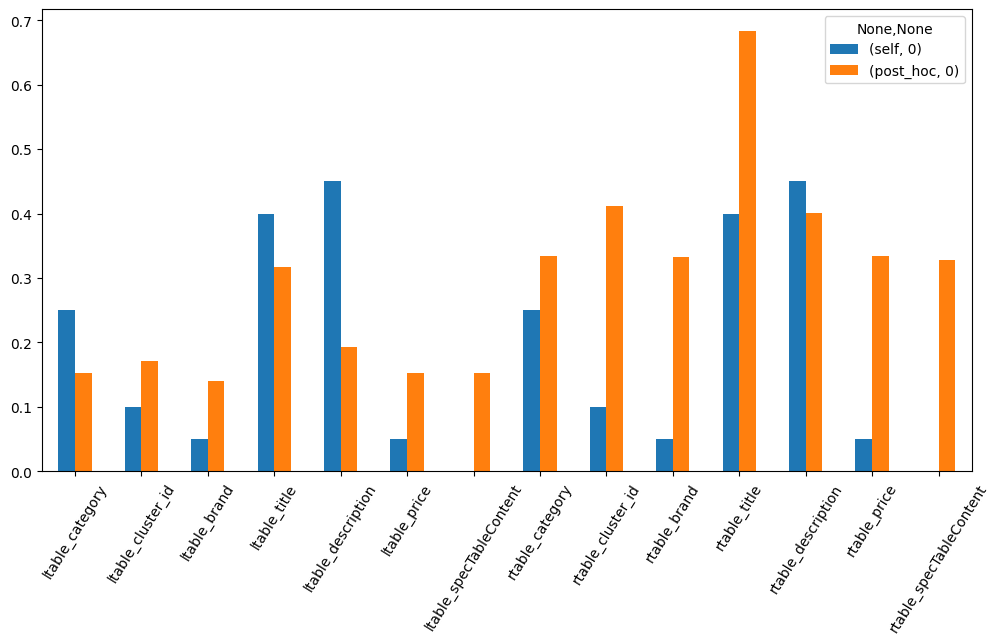

In [110]:
explanations.T.plot(kind='bar', stacked=False, figsize=(12, 6), rot=58)

In [176]:
expl1 = [r[0] for r in sorted(explanations.iloc[0].to_dict().items(), key=operator.itemgetter(1), reverse=True)]
perturb_for_target_label(wdc_cameras_row, expl1, predict_fn, label=int(prediction.values), k=5)

/var/folders/mr/6xnd0hrs6257283btx8ff88r0000gn/T/ipykernel_5310/2824996153.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  perturb_for_target_label(wdc_cameras_row, expl1, predict_fn, label=int(prediction.values), k=5)

100%|██████████| 1/1 [00:04<00:00,  4.57s/it]


(    ltable_category ltable_cluster_id ltable_brand  \
 0  Camera_and_Photo          660483.0          nan   
 
                                         ltable_title  \
 0   "Canon Lens Hood ES-52 for EF 44mm f/2.8 STM"...   
 
                                   ltable_description ltable_price  \
 0  "  Prevents stray light from entering the lens...          nan   
 
   ltable_specTableContent   rtable_category rtable_cluster_id rtable_brand  \
 0                     nan  Camera_and_Photo         3092335.0          nan   
 
                                         rtable_title  \
 0   "Canon Lens Hood ES-52 for EF 44mm f/2.8 STM"...   
 
                                   rtable_description rtable_price  \
 0  "  Prevents stray light from entering the lens...          nan   
 
   rtable_specTableContent  
 0                     nan  ,
 array([1]))

In [184]:
res = []

k_range = 6

for i in range(len(explanations)):
    expl = explanations.iloc[i]
    explainer = expl.name[0]
    salient_features = [r[0] for r in sorted(expl.to_dict().items(), key=operator.itemgetter(1), reverse=True)]
    for k in range(k_range):
        pert, pred = perturb_for_target_label(wdc_cameras_row, salient_features, predict_fn, label=int(prediction.values), k=k)
        cr = {'prediction': pred, 'perturbed': pert, 'explainer': explainer}
        res.append(cr)

consistency = pd.DataFrame(res)


/var/folders/mr/6xnd0hrs6257283btx8ff88r0000gn/T/ipykernel_5310/493151998.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pert, pred = perturb_for_target_label(wdc_cameras_row, salient_features, predict_fn, label=int(prediction.values), k=k)

100%|██████████| 1/1 [00:01<00:00,  1.99s/it]
/var/folders/mr/6xnd0hrs6257283btx8ff88r0000gn/T/ipykernel_5310/493151998.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pert, pred = perturb_for_target_label(wdc_cameras_row, salient_features, predict_fn, label=int(prediction.values), k=k)

100%|██████████| 1/1 [00:01<00:00,  1.98s/it]
/var/folders/mr/6xnd0hrs6257283btx8ff88r0000gn/T/ipykernel_5

In [189]:
consistency[['explainer','prediction']].groupby(['explainer']).sum()/k_range

,prediction
explainer,
post_hoc,0.833333
self,0.500000
